In [1]:
import os 
import ipyvolume as ipv
from tyssue import HistoryHdf5
from tyssue.draw import browse_history
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
from scipy.optimize import curve_fit

from polarity.toolbox import open_sheet
import seaborn as sns

In [ ]:
filename = '1.0_polarity_[1157, 232, 509]_perturbation_1324094.302695705_ve_0'
history = HistoryHdf5.from_archive(
    '/home/admin-suz/Documents/Code/polarity/notebooks/20200303-variability/'+filename+'/'+filename+'.hf5'
    )

specs = {
    "face": {
        "visible": True,
        "color":lambda sheet :sheet.face_df.fold,
        #"color": lambda sheet : sheet.face_df['ablate'],
        "colormap": 'Blues',
        "alpha": 0.2
    },
    "edge": {
        "visible": True,
        "color":'black',
    },
}


browse_history(history, coords=['z', 'x', 'y'], **specs)
ipv.style.use("dark")
ipv.style.box_off()
ipv.pylab.style.axes_off()

In [2]:
def update_latrad(sheet):
    radius_ = sheet.vert_df.eval("(x**2+y**2)**0.5")
    sheet.vert_df['depth'] = radius_.max() - radius_
    sheet.vert_df['latitude'] = np.arctan2(sheet.vert_df.y, sheet.vert_df.x)

In [408]:
from scipy.signal import find_peaks
from scipy.optimize import brentq

def get_slice(sheet, l0=0, largeur=0.3):
    """ l0 should be between -π and π
    
    """
    vert = sheet.vert_df[
        (sheet.vert_df.latitude<l0+largeur/2)
        & (sheet.vert_df.latitude>l0-largeur/2)
        & (sheet.vert_df.z>-30) & (sheet.vert_df.z<30)
    ].copy()
    return vert
    
def measure_fold(sheet, l0=0.0, largeur=0.3, t=None, window=40, l0_to_measure=None, pos='left'):
    
    if t is None:
        t = np.arange(-window/4, window/4+1, window/8)
    vert = get_slice(sheet, l0, largeur)
    vert.sort_values('z', inplace=True)
    tck = splrep(vert['z'], vert['depth'], t=t, k=3)
    zz = np.linspace(-window/2, window/2, 100)
    i_depth = splev(zz, tck)
    i_slope = splev(zz, tck, der=1)
    
    z_sl = zz[np.argmax(i_slope)]
    z_sr = zz[np.argmin(i_slope)]
    try:
        z_depth = brentq(lambda z: splev(z, tck, der=1), z_sl, z_sr)
    except ValueError:
        z_depth = np.nan
        
    if l0_to_measure is None:
        i_depth_max = i_depth.max()
    else: 
        if l0_to_measure != l0:
            i_depth_max = i_depth.max()
        else:
            if pos=='left':
                i_depth_max = i_depth[:int(len(i_depth)/2)].max()
            else:
                i_depth_max = i_depth[int(len(i_depth)/2):].max()
#             if pos == 'left':
#                 for i in range(int(len(i_depth)/2)-1, 0, -1):
#                     if i_depth[i]>i_depth[i+1]:
#                         i_depth_max = i_depth[i+1]
#                         break
#                     else : 
#                         i_depth_max = i_depth[i+1]
#             else: 
#                 for i in range(int(len(i_depth)/2), len(i_depth)-1):
#                     if i_depth[i]<i_depth[i+1]:
#                         i_depth_max = i_depth[i]
#                         break
#                     else : 
#                         i_depth_max = i_depth[i]
            
            
        
        
    measures = {
        "i_depth":i_depth,
        "depth" : i_depth_max,
        "z_depth": z_depth,
        "slope_left" : i_slope.max(), 
        "slope_right" : -i_slope.min(),
        "z_sl" : z_sl,
        "z_sr" : z_sr,
    }
    
    
    return measures

def measure_fold_whole_sheet(sheet, nbins=100, **kwargs):
    update_latrad(sheet)
    all_measures = []
    lats = np.linspace(-np.pi, np.pi, nbins)
    for lat in lats:
        all_measures.append(measure_fold(sheet, l0=lat, **kwargs))
    
    all_measures = pd.DataFrame.from_records(all_measures)
    all_measures.index = lats
    return all_measures



In [406]:
SIM_DIR = '/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20200205-variability'

list_dir = os.listdir(SIM_DIR)

In [5]:
def find_max_depth_time(history, window):
    with pd.HDFStore(history.hf5file, "r") as file:
        v_pos = file.select("vert", columns=["time", "x", "y", "z"]).reset_index()
    center = v_pos[np.abs(v_pos['z']) < window]
    center['distance'] = np.sqrt((center.x-center.x.mean())**2+(center.y-center.y.mean())**2)
    distances = center.groupby('time')['distance'].mean()
    time = distances.idxmin()
    return time

In [517]:
## 1-Faire la mesure de tout les controles (= sans perturbation)
datas = pd.DataFrame()

for d in range(0,12,2):
    for i in range(0,40):
        for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[d])) if f.split('_')[-1] == str(i)):

            
            history = HistoryHdf5.from_archive(
                os.path.join(os.path.join(SIM_DIR,list_dir[d]),f+'/out.hf5')
                )
            t = find_max_depth_time(history, 15)
            
            print(d, i, t)
            sheet = history.retrieve(t)
            
            all_measures = measure_fold_whole_sheet(sheet, nbins=24, window=40)
            all_measures.reset_index(drop=False, inplace=True)
            all_measures['pola'] = f.split('_')[0]
            all_measures['perturb'] = f.split('_')[2]
            all_measures['id'] = f.split('_')[-1]
            
            datas=pd.concat([datas, all_measures], axis=0)

            
            
 
            
            
datas.to_csv("datas_new_n50.csv", sep=';')
data_save = datas.copy()

/home/admin-suz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0 0 53.0
0 1 53.0
0 2 52.0
0 3 52.0
0 4 54.0
0 5 52.0
0 6 53.0
0 7 53.0
0 8 54.0
0 9 52.0
0 10 54.0
0 11 53.0
0 12 53.0
0 13 55.0
0 14 55.0
0 15 52.0
0 16 48.0
0 17 51.0
0 18 55.0
0 19 54.0
0 20 49.0
0 21 55.0
0 22 52.0
0 23 52.0
0 24 53.0
0 25 53.0
0 26 51.0
0 27 55.0
0 28 53.0
0 29 54.0
0 30 50.0
0 31 52.0
0 32 54.0
0 33 55.0
0 34 53.0
0 35 53.0
0 36 54.0
0 37 54.0
0 38 53.0
0 39 54.0
2 0 57.0
2 1 56.0
2 2 57.0
2 3 57.0
2 4 56.0
2 5 57.0
2 6 57.0
2 7 57.0
2 8 57.0
2 9 57.0
2 10 58.0
2 11 57.0
2 12 59.0
2 13 58.0
2 14 57.0
2 15 57.0
2 16 57.0
2 17 57.0
2 18 57.0
2 19 56.0
2 20 57.0
2 21 58.0
2 22 58.0
2 23 58.0
2 24 57.0
2 25 55.0
2 26 59.0
2 27 55.0
2 28 57.0
2 29 56.0
2 30 58.0
2 31 56.0
2 32 58.0
2 33 58.0
2 34 56.0
2 35 57.0
2 36 59.0
2 37 56.0
2 38 56.0
2 39 58.0
4 0 60.0
4 1 60.0
4 2 60.0
4 3 59.0
4 4 60.0
4 5 60.0
4 6 59.0
4 7 59.0
4 8 59.0
4 9 60.0
4 10 61.0
4 11 58.0
4 12 60.0
4 13 60.0
4 14 60.0
4 15 61.0
4 16 60.0
4 17 60.0
4 18 60.0
4 19 60.0
4 20 59.0
4 21 61.0
4 22 60.0


In [518]:
## 2-Faire la mesure de tout les perturbés avec une polarité de 1
datas = data_save.copy()
d=11
pos_max_05 = []
for i in range(0,40):
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[d])) if f.split('_')[-1] == str(i)):

        if f.split('_')[0]=='1.0':
            history = HistoryHdf5.from_archive(
                os.path.join(os.path.join(SIM_DIR,list_dir[d]),f+'/out.hf5')
                )
            t = find_max_depth_time(history, 15)

            print(d, i, t)
            sheet = history.retrieve(t)

            all_measures = measure_fold_whole_sheet(sheet, nbins=24, window=40)
            all_measures.reset_index(drop=False, inplace=True)
            all_measures['pola'] = f.split('_')[0]
            all_measures['perturb'] = f.split('_')[2]
            all_measures['id'] = f.split('_')[-1]

            datas=pd.concat([datas, all_measures], axis=0)

            fold = all_measures['z_depth']
            if abs(fold.min()) > abs(fold.max()):
                pos_max_05.append(list(fold).index(np.nanmin(fold)))
            else: 
                pos_max_05.append(list(fold).index(np.nanmax(fold)))
            
datas.to_csv("datas_new2_n50.csv", sep=';')
data_save2 = datas.copy()

/home/admin-suz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


11 0 70.0
11 1 60.0
11 2 65.0
11 3 54.0
11 4 72.0
11 5 69.0
11 6 61.0
11 7 66.0
11 8 66.0
11 9 71.0
11 10 60.0
11 11 72.0
11 12 65.0
11 13 61.0
11 14 64.0
11 15 64.0
11 16 68.0
11 17 66.0
11 18 57.0
11 19 68.0
11 20 57.0
11 21 68.0
11 22 65.0
11 23 68.0
11 24 71.0
11 25 59.0
11 26 56.0
11 27 62.0
11 28 61.0
11 29 69.0
11 30 63.0
11 31 55.0
11 32 72.0
11 33 64.0
11 34 62.0
11 35 61.0
11 36 62.0
11 37 55.0
11 38 62.0
11 39 67.0


In [519]:
datas = data_save2.copy()

lats = np.linspace(-np.pi, np.pi, 24)
for d in range(1,11,2):
    for i in range(0,40):
        for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[d])) if f.split('_')[-1] == str(i)):

            
            history = HistoryHdf5.from_archive(
                os.path.join(os.path.join(SIM_DIR,list_dir[d]),f+'/out.hf5')
                )
            t = find_max_depth_time(history, 15)
            
            print(d, i, t)
            sheet = history.retrieve(t)
            
            if pos_max_05[i]>12:
                pos_ = 'right'
            else :
                pos_ ='left'
            
            all_measures = measure_fold_whole_sheet(sheet, nbins=24, window=40, 
                                                    l0_to_measure=lats[pos_max_05[i]],
                                                    pos=pos_)
            all_measures.reset_index(drop=False, inplace=True)
            all_measures['pola'] = f.split('_')[0]
            all_measures['perturb'] = f.split('_')[2]
            all_measures['id'] = f.split('_')[-1]
            
            datas=pd.concat([datas, all_measures], axis=0) 
                        

datas.to_csv("datas_new3_n50.csv", sep=';')
data_save3 = datas.copy()

/home/admin-suz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1 0 52.0
1 1 49.0
1 2 50.0
1 3 49.0
1 4 57.0
1 5 51.0
1 6 48.0
1 7 54.0
1 8 52.0
1 9 55.0
1 10 48.0
1 11 58.0
1 12 52.0
1 13 49.0
1 14 52.0
1 15 53.0
1 16 57.0
1 17 52.0
1 18 48.0
1 19 55.0
1 20 49.0
1 21 52.0
1 22 52.0
1 23 50.0
1 24 56.0
1 25 47.0
1 26 47.0
1 27 53.0
1 28 53.0
1 29 54.0
1 30 51.0
1 31 49.0
1 32 53.0
1 33 52.0
1 34 53.0
1 35 48.0
1 36 53.0
1 37 46.0
1 38 49.0
1 39 57.0
3 0 53.0
3 1 50.0
3 2 52.0
3 3 50.0
3 4 59.0
3 5 57.0
3 6 52.0
3 7 51.0
3 8 56.0
3 9 56.0
3 10 51.0
3 11 60.0
3 12 53.0
3 13 50.0
3 14 53.0
3 15 56.0
3 16 59.0
3 17 55.0
3 18 47.0
3 19 59.0
3 20 51.0
3 21 56.0
3 22 55.0
3 23 52.0
3 24 59.0
3 25 51.0
3 26 50.0
3 27 55.0
3 28 55.0
3 29 55.0
3 30 56.0
3 31 51.0
3 32 59.0
3 33 54.0
3 34 55.0
3 35 53.0
3 36 54.0
3 37 50.0
3 38 51.0
3 39 59.0
5 0 58.0
5 1 54.0
5 2 57.0
5 3 51.0
5 4 63.0
5 5 61.0
5 6 55.0
5 7 55.0
5 8 59.0
5 9 60.0
5 10 52.0
5 11 62.0
5 12 55.0
5 13 52.0
5 14 55.0
5 15 55.0
5 16 61.0
5 17 57.0
5 18 52.0
5 19 62.0
5 20 52.0
5 21 60.0
5 22 58.0


/home/admin-suz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0 2.0488647740802994 2.1467982080606873
1 -2.86841068371242 -3.1217946114995083
2 2.3220467439576726 2.4911280866733794
3 0.4097729548160598 0.0031705669545444323
4 -0.9561368945708066 -0.7661685860251353
5 -2.86841068371242 -2.898804513127771
6 1.2293188644481798 1.2683515117385293
7 -0.40977295481606013 -0.8314363587486862
8 1.7756828042029262 1.906026003552031
9 0.6829549246934334 0.9646466950163913
10 0.9561368945708066 2.1937630293836934
11 0.4097729548160598 0.24594017853139405
12 -2.3220467439576735 -2.282717492090961
13 0.9561368945708066 0.06823240453727328
14 0.9561368945708066 0.9928090851486906
15 0.4097729548160598 0.3378946863869818
16 0.1365909849386866 0.15295683251712097
17 -0.40977295481606013 -0.14995927782534862
18 -1.5025008343255533 -1.5626511027263268
19 -0.1365909849386866 -0.22053249439580655
20 -0.9561368945708066 -1.0832556149889616
21 1.2293188644481798 1.7540518378737726
22 0.6829549246934334 1.0884642927063843
23 0.9561368945708066 2.396806343454711
24 -2.

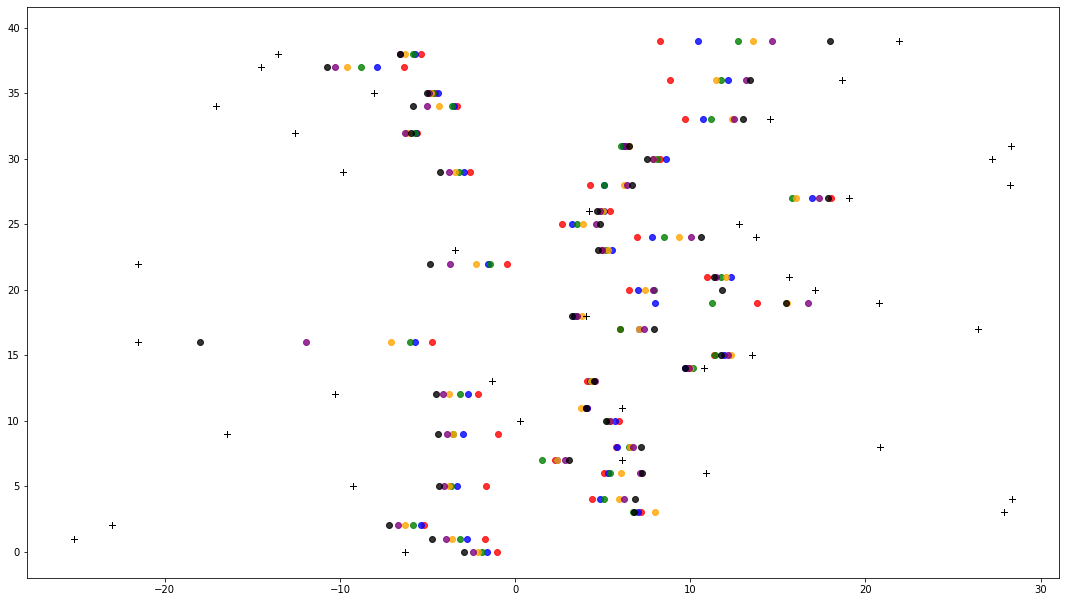

In [521]:
datas = pd.read_csv('datas_new3_n40.csv', sep=';', index_col=0)
datas.reset_index(inplace=True)
fig, ax = plt.subplots()
colors=['red', 'blue', 'green', 'orange', 'purple', 'black']

for id_ in range(0, 40):
    
    #recuperer position perturbation
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[11])) if f.split('_')[-1] == str(id_)):
        if f.split('_')[0]=='1.0':
            history = HistoryHdf5.from_archive(
                os.path.join(os.path.join(SIM_DIR,list_dir[11]),f+'/out.hf5')
                )
            t = find_max_depth_time(history, 15)
            sheet = history.retrieve(t)
            
            sheet.face_df['latitude'] = np.arctan2(sheet.face_df.y, sheet.face_df.x)
            
            pos_perturb_z = sheet.face_df[sheet.face_df.is_mesoderm==1].z.to_numpy()
            pos_perturb_latitude = sheet.face_df[sheet.face_df.is_mesoderm==1].latitude.to_numpy()
            
            
    max_depth = []
    i=0
    for pola_ in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,]:
            
        index_ = datas[(datas.id==id_)
                     & (datas.pola==pola_)
                     & (datas.perturb=='-1')].index
        fold = datas.loc[index_, 'z_depth']

        datas.loc[index_, 'fold_correct'] = fold

        max_depth.append(list(fold)[pos_max_05[id_]])
        pos_max_depth = pos_max_05[id_]
        
        #ax.scatter(list(fold)[pos_max_05[id_]], pos_max_05[id_], color='black', alpha=0.2)
            
        index_ = datas[(datas.id==id_)
                     & (datas.pola==pola_)
                     & (datas.perturb!='-1')].index
        fold = datas.loc[index_, 'z_depth']
        

        datas.loc[index_, 'fold_correct'] = fold

        max_depth.append(list(fold)[pos_max_05[id_]])
        pos_max_depth = pos_max_05[id_]
        
         
        ax.scatter(list(fold)[pos_max_05[id_]],id_, color=colors[i], alpha=0.8)
        
        def find_nearest(array, value):
            array = np.asarray(array)
            idx = (np.abs(array - value)).argmin()
            return idx
        
        zi = find_nearest(pos_perturb_latitude, datas.loc[list(index_)[pos_max_05[id_]]]['index'])
        ax.plot(pos_perturb_z[zi], id_,'k+', alpha=1)
        
        i+=1
    print(id_, datas.loc[list(index_)[pos_max_05[id_]]]['index'], pos_perturb_latitude[zi])
fig.set_size_inches(18.5, 10.5, forward=True)

/home/admin-suz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0 2.0488647740802994 2.1467982080606873
1 -2.86841068371242 -3.1217946114995083
2 2.3220467439576726 2.4911280866733794
3 0.4097729548160598 0.0031705669545444323
4 -0.9561368945708066 -0.7661685860251353
5 -2.86841068371242 -2.898804513127771
6 1.2293188644481798 1.2683515117385293
7 -0.40977295481606013 -0.8314363587486862
8 1.7756828042029262 1.906026003552031
9 0.6829549246934334 0.9646466950163913
10 0.9561368945708066 2.1937630293836934
11 0.4097729548160598 0.24594017853139405
12 -2.3220467439576735 -2.282717492090961
13 0.9561368945708066 0.06823240453727328
14 0.9561368945708066 0.9928090851486906
15 0.4097729548160598 0.3378946863869818
16 0.1365909849386866 0.15295683251712097
17 -0.40977295481606013 -0.14995927782534862
18 -1.5025008343255533 -1.5626511027263268
19 -0.1365909849386866 -0.22053249439580655
20 -0.9561368945708066 -1.0832556149889616
21 1.2293188644481798 1.7540518378737726
22 0.6829549246934334 1.0884642927063843
23 0.9561368945708066 2.396806343454711
24 -2.

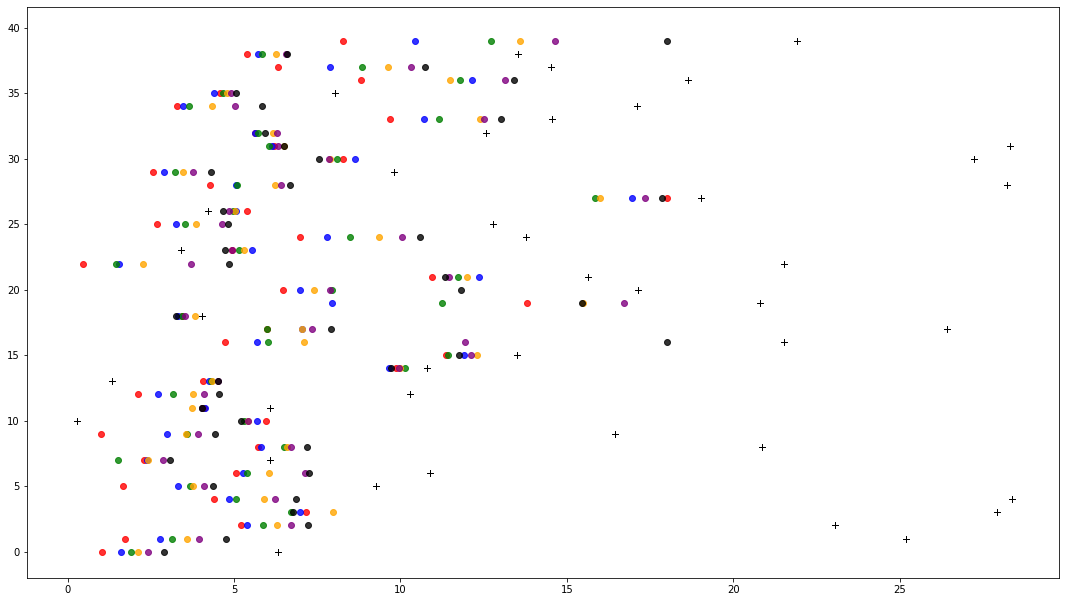

In [523]:
datas = pd.read_csv('datas_new3_n40.csv', sep=';', index_col=0)
datas.reset_index(inplace=True)
fig, ax = plt.subplots()
colors=['red', 'blue', 'green', 'orange', 'purple', 'black']

for id_ in range(0, 40):
    
    #recuperer position perturbation
    for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[11])) if f.split('_')[-1] == str(id_)):
        if f.split('_')[0]=='1.0':
            history = HistoryHdf5.from_archive(
                os.path.join(os.path.join(SIM_DIR,list_dir[11]),f+'/out.hf5')
                )
            t = find_max_depth_time(history, 15)
            sheet = history.retrieve(t)
            
            sheet.face_df['latitude'] = np.arctan2(sheet.face_df.y, sheet.face_df.x)
            
            pos_perturb_z = sheet.face_df[sheet.face_df.is_mesoderm==1].z.to_numpy()
            pos_perturb_latitude = sheet.face_df[sheet.face_df.is_mesoderm==1].latitude.to_numpy()
            
            
    max_depth = []
    i=0
    for pola_ in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,]:
            
        index_ = datas[(datas.id==id_)
                     & (datas.pola==pola_)
                     & (datas.perturb=='-1')].index
        fold = datas.loc[index_, 'z_depth']

        datas.loc[index_, 'fold_correct'] = fold

        max_depth.append(list(fold)[pos_max_05[id_]])
        pos_max_depth = pos_max_05[id_]
        
        #ax.scatter(list(fold)[pos_max_05[id_]], pos_max_05[id_], color='black', alpha=0.2)
            
        index_ = datas[(datas.id==id_)
                     & (datas.pola==pola_)
                     & (datas.perturb!='-1')].index
        fold = datas.loc[index_, 'z_depth']
        

        datas.loc[index_, 'fold_correct'] = fold

        max_depth.append(list(fold)[pos_max_05[id_]])
        pos_max_depth = pos_max_05[id_]
        
         
        ax.scatter(abs(list(fold)[pos_max_05[id_]]), id_, color=colors[i], alpha=0.8)
        
        def find_nearest(array, value):
            array = np.asarray(array)
            idx = (np.abs(array - value)).argmin()
            return idx
        
        zi = find_nearest(pos_perturb_latitude, datas.loc[list(index_)[pos_max_05[id_]]]['index'])
        ax.plot(abs(pos_perturb_z[zi]), id_,'k+', alpha=1)
        
        i+=1
    print(id_, datas.loc[list(index_)[pos_max_05[id_]]]['index'], pos_perturb_latitude[zi])
fig.set_size_inches(18.5, 10.5, forward=True)

In [522]:
datas = pd.read_csv('datas_new3_n40.csv', sep=';', index_col=0)
datas.reset_index(inplace=True)
colors=['red', 'blue', 'green', 'orange', 'purple', 'black']

result_control = []
result_perturb = []
for id_ in range(0, 40):    
    max_depth_control = []
    max_depth_perturb = []
    i=0
    for pola_ in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,]:
            
        index_ = datas[(datas.id==id_)
                     & (datas.pola==pola_)
                     & (datas.perturb=='-1')].index
        fold = datas.loc[index_, 'z_depth']

        datas.loc[index_, 'fold_correct'] = fold

        max_depth.append(list(fold)[pos_max_05[id_]])
        pos_max_depth = pos_max_05[id_]
        max_depth_control.append(list(fold)[pos_max_05[id_]])
            
        index_ = datas[(datas.id==id_)
                     & (datas.pola==pola_)
                     & (datas.perturb!='-1')].index
        fold = datas.loc[index_, 'z_depth']

        datas.loc[index_, 'fold_correct'] = fold

        max_depth.append(list(fold)[pos_max_05[id_]])
        pos_max_depth = pos_max_05[id_]
        max_depth_perturb.append(list(fold)[pos_max_05[id_]])
         
        i+=1
    result_control.append(max_depth_control)
    result_perturb.append(max_depth_perturb)
        
result_control = pd.DataFrame(np.array(result_control))
result_control.columns=['0.5', '0.6','0.7','0.8','0.9','1.0']
result_perturb = pd.DataFrame(np.array(result_perturb))
result_perturb.columns=['0.5', '0.6','0.7','0.8','0.9','1.0']


In [560]:
stat.describe(result_perturb).variance

array([35.15576288, 39.34065818, 42.48880522, 49.64498092, 58.85894156,
       70.98462261])

In [524]:
print(stat.levene((result_perturb['0.5']), (result_perturb['1.0'])))
print(stat.levene(abs(result_perturb['0.5']), abs(result_perturb['1.0']))) #val abs

LeveneResult(statistic=3.761493199857967, pvalue=0.05606148638982502)
LeveneResult(statistic=0.7594851427343888, pvalue=0.3861642317714108)


In [579]:
var = stat.describe(abs(res)).variance
var

array([ 7.87176243,  8.87036266,  9.26881272,  9.56713417, 10.44339666,
       14.82470024])

In [578]:
res.drop(19, inplace=True)

SpearmanrResult(correlation=1.0, pvalue=0.0)
SpearmanrResult(correlation=1.0, pvalue=0.0)


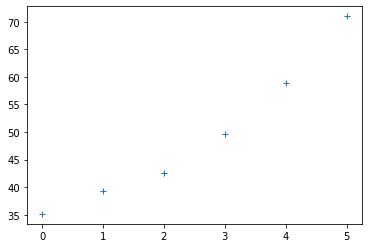

In [571]:
import scipy.stats as stat
plt.plot(stat.describe(result_perturb).variance, '+')
var = stat.describe(result_perturb).variance

print(stat.spearmanr([list(var),['0.5', '0.6','0.7','0.8','0.9','1.0']], axis=1))


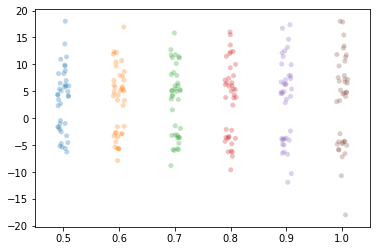

In [572]:
fig, ax = plt.subplots()
#sns.stripplot(data=(result_control), jitter=True, ax=ax)
sns.stripplot(data=(result_perturb), jitter=True, alpha=0.3, ax=ax)

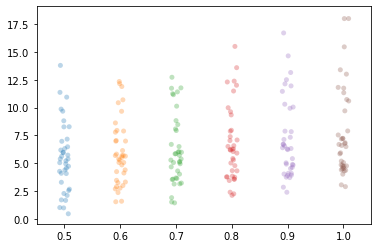

In [527]:
res = result_perturb.drop(27)
res = res.drop(18)
fig, ax = plt.subplots()
#sns.stripplot(data=(rel_control1[['0.5', '0.6','0.7','0.8','0.9','1.0']]), jitter=True, ax=ax)
sns.stripplot(data=abs(res), jitter=True, alpha=0.3, ax=ax)

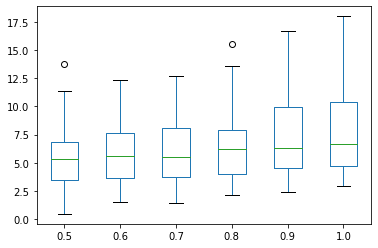

In [532]:
result_perturb2 = abs(res)
result_perturb2.boxplot(grid=False,)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdcb201e590>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdcb1844650>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdcb1844cd0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fdcb2458e10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fdcb341d950>,
 'means': [<matplotlib.lines.Line2D at 0x7fdcb05e8ed0>,
  <matplotlib.lines.Line2D at 0x7fdcb1b4f0d0>]}

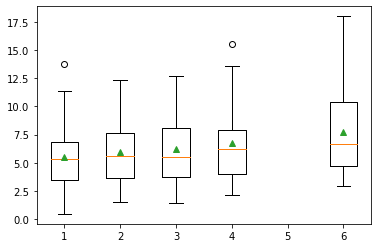

In [535]:
plt.boxplot(result_perturb2.T, showmeans=True)

In [347]:
# Recuperation de la distance max au même endroit selon la
# position de la distance max des simulations sans polarité
# Separation des datas pour un patron d'apoptose défini
datas = pd.read_csv('datas_new3.csv', sep=';', index_col=0)

datas_1 = datas[datas.id.astype(int)<10]
datas_2 = datas[datas.id.astype(int)>=10]

datas.reset_index(inplace=True)
min_, max_ = 1, 23

datas['fold_correct'] = 0

result_control = []
z_depth=[]
first = 1
for id_ in range(min_, max_):
    if first == 1:
        z_depth = datas[(datas.perturb=='-1') & (datas.id==id_)][['index', 'z_depth']]
        first = 0
    else:
        z_depth = pd.concat([z_depth, datas[(datas.perturb=='-1') & (datas.id==id_)][['index','z_depth']]], axis = 0 , ignore_index=True)

mean_fold = z_depth.groupby('index')['z_depth'].mean().to_numpy()
        
for id_ in range(min_, max_):    
    max_depth = []
    for pola_ in [1.0, 0.5, 0.6, 0.7, 0.8, 0.9]:
        if pola_ == 1.0:
            
            index_ = datas[(datas.id==id_)
                         & (datas.pola==pola_)
                         & (datas.perturb=='-1')].index
            fold = datas.loc[index_, 'z_depth']
            
            datas.loc[index_, 'fold_correct'] = fold

            max_depth.append(list(fold)[pos_max_05[id_]])
            pos_max_depth = pos_max_05[id_]
            
        else: 
            
            index_ = datas[(datas.id==id_)
                         & (datas.pola==pola_)
                         & (datas.perturb=='-1')].index
            fold = datas.loc[index_, 'z_depth']-mean_fold
            datas.loc[index_, 'fold_correct'] = fold
            max_depth.append(list(fold)[pos_max_05[id_]])
            

    result_control.append(max_depth)
        
result_control = pd.DataFrame(np.array(result_control))
result_control.columns=['0.5', '0.6','0.7','0.8','0.9','1.0']

result_perturb = []
for id_ in range(min_, max_):
    max_depth = []
    
    for pola_ in [1.0, 0.5, 0.6, 0.7, 0.8, 0.9]:
        if pola_ == 1.0:
            index_ = datas[(datas.id==id_)
                         & (datas.pola==pola_)
                         & (datas.perturb!='-1')].index
            fold = datas.loc[index_, 'z_depth']
            datas.loc[index_, 'fold_correct'] = fold
            
            max_depth.append(list(fold)[pos_max_05[id_]])
            pos_max_depth = pos_max_05[id_]
            
        else:
            index_ = datas[(datas.id==id_)
                         & (datas.pola==pola_)
                         & (datas.perturb!='-1')].index
            fold = datas.loc[index_, 'z_depth']-mean_fold

            datas.loc[index_, 'fold_correct'] = fold
            max_depth.append(list(fold)[pos_max_05[id_]])
            
            
    result_perturb.append(max_depth)
        
result_perturb = pd.DataFrame(np.array(result_perturb))
result_perturb.columns=['0.5', '0.6','0.7','0.8','0.9','1.0']


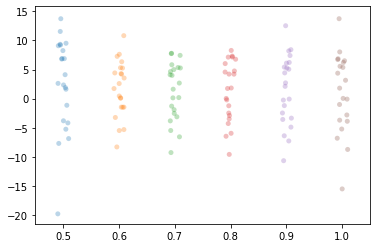

In [348]:
abs_control = (result_control)
rel_control1 = (abs_control - np.mean(abs_control, axis=1)[:,None])

abs_perturb = (result_perturb)
rel_perturb1 = (abs_perturb - np.mean(abs_control, axis=1)[:,None])

fig, ax = plt.subplots()
#sns.stripplot(data=(rel_control1[['0.5', '0.6','0.7','0.8','0.9','1.0']]), jitter=True, ax=ax)
sns.stripplot(data=(rel_perturb1), jitter=True, alpha=0.3, ax=ax)

In [326]:
# Separation des datas pour un patron d'apoptose défini
datas = pd.read_csv('datas_new3.csv', sep=';', index_col=0)

datas_1 = datas[datas.id.astype(int)<10]
datas_2 = datas[datas.id.astype(int)>=10]

In [327]:
# Recuperation de la distance max au même endroit selon la
# position de la distance max des simulations sans polarité

datas.reset_index(inplace=True)
min_, max_ = 1, 23

datas['fold_correct'] = 0

result_control = []
z_depth=[]
first = 1
for id_ in range(min_, max_):
    if first == 1:
        z_depth = datas[(datas.perturb=='-1') & (datas.id==id_)][['index', 'z_depth']]
        first = 0
    else:
        z_depth = pd.concat([z_depth, datas[(datas.perturb=='-1') & (datas.id==id_)][['index','z_depth']]], axis = 0 , ignore_index=True)

mean_fold = z_depth.groupby('index')['z_depth'].mean().to_numpy()
        
for id_ in range(min_, max_):    
    max_depth = []
    for pola_ in [1.0, 0.5, 0.6, 0.7, 0.8, 0.9]:
        if pola_ == 1.0:
            
            index_ = datas[(datas.id==id_)
                         & (datas.pola==pola_)
                         & (datas.perturb=='-1')].index
            fold = datas.loc[index_, 'z_depth']
            
            datas.loc[index_, 'fold_correct'] = fold
            if abs(fold.min()) > abs(fold.max()):
                max_depth.append(fold.min())
                pos_max_depth = list(fold).index(np.nanmin(fold))
            else: 
                max_depth.append(fold.max())
                pos_max_depth = list(fold).index(np.nanmax(fold))
        else: 
            
            index_ = datas[(datas.id==id_)
                         & (datas.pola==pola_)
                         & (datas.perturb=='-1')].index
            fold = datas.loc[index_, 'z_depth']-mean_fold
            datas.loc[index_, 'fold_correct'] = fold
            max_depth.append(list(fold)[pos_max_depth])
            

    result_control.append(max_depth)
        
result_control = pd.DataFrame(np.array(result_control))
result_control.columns=['0.5', '0.6','0.7','0.8','0.9','1.0']

result_perturb = []
for id_ in range(min_, max_):
    max_depth = []
    
    for pola_ in [1.0, 0.5, 0.6, 0.7, 0.8, 0.9]:
        if pola_ == 1.0:
            index_ = datas[(datas.id==id_)
                         & (datas.pola==pola_)
                         & (datas.perturb!='-1')].index
            fold = datas.loc[index_, 'z_depth']
            datas.loc[index_, 'fold_correct'] = fold
            if abs(fold.min()) > abs(fold.max()):
                max_depth.append(fold.min())
                pos_max_depth = list(fold).index(np.nanmin(fold))
            else: 
                max_depth.append(fold.max())
                pos_max_depth = list(fold).index(np.nanmax(fold))
        else:
            index_ = datas[(datas.id==id_)
                         & (datas.pola==pola_)
                         & (datas.perturb!='-1')].index
            fold = datas.loc[index_, 'z_depth']-mean_fold

            datas.loc[index_, 'fold_correct'] = fold
            max_depth.append(list(fold)[pos_max_depth])
            
            
    result_perturb.append(max_depth)
        
result_perturb = pd.DataFrame(np.array(result_perturb))
result_perturb.columns=['0.5', '0.6','0.7','0.8','0.9','1.0']


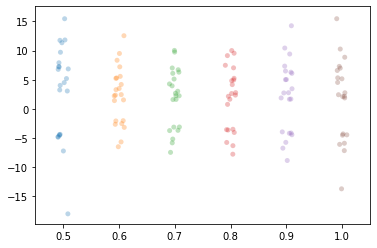

In [332]:
abs_control = (result_control)
rel_control1 = (abs_control - np.mean(abs_control, axis=1)[:,None])

abs_perturb = (result_perturb)
rel_perturb1 = (abs_perturb - np.mean(abs_control, axis=1)[:,None])

fig, ax = plt.subplots()
#sns.stripplot(data=(rel_control1[['0.5', '0.6','0.7','0.8','0.9','1.0']]), jitter=True, ax=ax)
sns.stripplot(data=(result_perturb), jitter=True, alpha=0.3, ax=ax)

In [333]:
result_perturb

,0.5,0.6,0.7,0.8,0.9,1.0
0,-4.764803,-2.071006,-3.129264,-3.496911,-3.945091,-4.295014
1,-7.218370,-5.668019,-5.827651,-6.309027,-6.737128,-7.156544
2,6.775179,5.299977,5.115011,4.828223,6.094920,NaN
3,6.850644,3.496656,3.949922,4.161266,5.009507,5.322207
4,-4.370514,-2.026305,-3.679234,-4.043193,-4.138263,-4.451056
5,7.244144,2.446547,2.676481,2.783082,3.449263,4.535030
6,3.063694,1.537693,1.621329,0.773393,1.653947,2.104685
7,7.188495,4.185008,4.276049,4.955202,5.032110,5.155636
8,-4.414842,-3.172919,-5.175143,-5.757464,-5.741365,-6.084704
9,5.197531,3.295360,3.026076,2.629930,2.769854,2.762027


In [57]:
# Recuperation de la distance max au même endroit selon la
# position de la distance max des simulations sans polarité
datas = datas.copy()
datas.reset_index(inplace=True)
min_, max_ = 0, 23

datas['fold_correct'] = 0

result_control = []
z_depth=[]
first = 1
for id_ in range(min_, max_):
    if first == 1:
        z_depth = datas[(datas.perturb==-1) & (datas.id==id_)][['index', 'z_depth']]
        first = 0
    else:
        z_depth = pd.concat([z_depth, datas[(datas.perturb==-1) & (datas.id==id_)][['index','z_depth']]], axis = 0 , ignore_index=True)

mean_fold = z_depth.groupby('index')['z_depth'].mean().to_numpy()
        
for id_ in range(min_, max_):    
    max_depth = []
    for pola_ in [1.0, 0.5, 0.6, 0.7, 0.8, 0.9]:
        if pola_ == 1.0:
            
            index_ = datas[(datas.id==id_)
                         & (datas.pola==pola_) 
                         & (datas.perturb==-1)].index
            fold = datas.loc[index_, 'z_depth']-mean_fold
            
            datas.loc[index_, 'fold_correct'] = fold
            if abs(fold.min()) > abs(fold.max()):
                max_depth.append(fold.min())
                pos_max_depth = list(fold).index(np.nanmin(fold))
            else: 
                max_depth.append(fold.max())
                pos_max_depth = list(fold).index(np.nanmax(fold))
        else: 
            
            index_ = datas[(datas.id==id_)
                         & (datas.pola==pola_) 
                         & (datas.perturb==-1)].index
            fold = datas.loc[index_, 'z_depth']-mean_fold
            datas.loc[index_, 'fold_correct'] = fold
            max_depth.append(list(fold)[pos_max_depth])
            

    result_control.append(max_depth)
        
result_control = pd.DataFrame(np.array(result_control))
result_control.columns=['0.5', '0.6','0.7','0.8','0.9','1.0']


result_perturb = []

for id_ in range(min_, max_):
    max_depth = []
    
    for pola_ in [1.0, 0.5, 0.6, 0.7, 0.8, 0.9]:
        if pola_ == 1.0:
            index_=datas[(datas.id==id_) 
                         & (datas.pola==pola_) 
                         & (datas.perturb!='-1')].index
            fold = datas.loc[index_, 'z_depth']-mean_fold
            datas.loc[index_, 'fold_correct'] = fold
            if abs(fold.min()) > abs(fold.max()):
                max_depth.append(fold.min())
                pos_max_depth = list(fold).index(np.nanmin(fold))
            else: 
                max_depth.append(fold.max())
                pos_max_depth = list(fold).index(np.nanmax(fold))
        else:
            index_=datas[(datas.id==id_) 
                         & (datas.pola==pola_) 
                         & (datas.perturb!='-1')].index
            fold = datas.loc[index_, 'z_depth']-mean_fold

            datas.loc[index_, 'fold_correct'] = fold
            max_depth.append(list(fold)[pos_max_depth])
            
            
    result_perturb.append(max_depth)
        
result_perturb = pd.DataFrame(np.array(result_perturb))
result_perturb.columns=['0.5', '0.6','0.7','0.8','0.9','1.0']


In [ ]:

fig, ax = plt.subplots()
no_pola = rel_control1[['1.0']]
no_pola['1.1']= rel_perturb1[['1.0']]
sns.stripplot(data=no_pola)

#plt.savefig('no_polarity_fig3.eps', dpi=300, transparent=True)

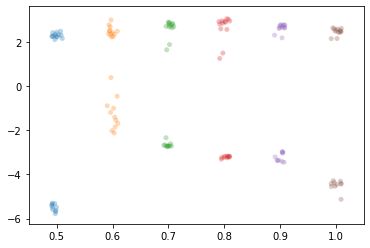

In [61]:
abs_control = (result_control)
rel_control1 = (abs_control - np.mean(abs_control, axis=1)[:,None])

abs_perturb = (result_perturb)
rel_perturb1 = (abs_perturb - np.mean(abs_control, axis=1)[:,None])

fig, ax = plt.subplots()
#sns.stripplot(data=(rel_control1[['0.5', '0.6','0.7','0.8','0.9','1.0']]), jitter=True, ax=ax)
sns.stripplot(data=(abs_perturb[['0.5', '0.6','0.7','0.8','0.9','1.0']]), jitter=True, alpha=0.3, ax=ax)

In [ ]:
import scipy.stats as stat
print(stat.describe(abs_perturb).variance)

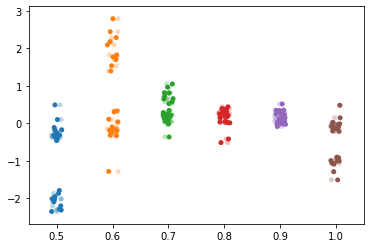

In [60]:
abs_control = (result_control)
rel_control2 = (abs_control - np.mean(abs_control, axis=1)[:,None])

abs_perturb = (result_perturb)
rel_perturb2 = (abs_perturb - np.mean(abs_control, axis=1)[:,None])

fig, ax = plt.subplots()
sns.stripplot(data=(rel_control2), jitter=True, ax=ax)
sns.stripplot(data=(rel_perturb2), jitter=True, alpha=0.3, ax=ax)


In [ ]:
rel_control = rel_control1.append(rel_control2)
rel_perturb = rel_perturb1.append(rel_perturb2)

#rel_control.to_csv("control.csv")
#rel_perturb.to_csv("perturb.csv")

fig, ax = plt.subplots()
sns.stripplot(data=abs(rel_control), jitter=True, ax=ax)
sns.stripplot(data=abs(rel_perturb), jitter=True, alpha=0.3, ax=ax)
#ax.set_rasterized(True)
#fig.savefig("output.pdf", dpi = 300, transparent=False)
#pdftops -eps my.pdf my.eps    commande à faire dans une console

In [ ]:
import scipy.stats as stat
print(stat.describe(rel_perturb).variance)
#ecart type
print(np.sqrt(stat.describe(rel_perturb).variance))
print(stat.describe(rel_control).variance)
from scipy.stats import ttest_rel
print(ttest_rel((rel_perturb['0.5']), (rel_perturb['1.0'])))

In [ ]:
sheet=history.retrieve(0)

In [ ]:
abs_control = abs(result_control)
rel_control = abs_control - np.mean(result_control, axis=1)[:,None]
rel_control.T.plot()

abs_perturb = abs(result_perturb)
rel_perturb = abs_perturb - np.mean(result_control, axis=1)[:,None]
rel_perturb.T.plot()



fig, ax = plt.subplots()
sns.stripplot(data=rel_control, jitter=True, ax=ax)
sns.stripplot(data=rel_perturb, jitter=True, alpha=0.3, ax=ax)

In [ ]:
abs_control = abs(result_control)
rel_control = result_control - np.mean(result_control.loc[:,0:5], axis=1)[:,None]

abs_perturb = abs(result_perturb)
rel_perturb = result_perturb - rel_perturb.loc[:,0][:,None]

fig, ax = plt.subplots()
sns.stripplot(data=(rel_control), jitter=True, ax=ax)
sns.stripplot(data=(rel_perturb), jitter=True, alpha=0.3, ax=ax)

In [ ]:
for idx, line in result_perturb.iterrows():
    fig, ax = plt.subplots()
    ax.plot(abs(line))

In [ ]:
sns.stripplot(data=abs(result_control), jitter=True)
sns.stripplot(data=abs(result_perturb), jitter=True, alpha = 0.3)


In [ ]:
import scipy.stats as stat
stat.describe(result_perturb).variance

In [ ]:
plt.boxplot(np.abs(result_control).T)
plt.boxplot(np.abs(result_perturb).T);

In [ ]:
from scipy.stats import ttest_ind
ttest_ind(abs(result_perturb[0]), abs(result_perturb[5]))

In [ ]:

for id, df in datas.groupby('id'):
    fig, ax = plt.subplots()
    df_ = df[df.perturb=='-1'].copy()
    ax.plot(df_.groupby('pola').std().z_depth)
    ax.set_title(id)
    
    df_ = df[df.perturb!='-1'].copy()
    ax.plot(df_.groupby('pola').std().z_depth)
    
    #plt.plot(datas.groupby('pola').mean().z_depth, '.')

In [ ]:
all_measures = measure_fold_whole_sheet(sheet, window=40)

sheet = sheet.extract_bounding_box(z_boundary=(-50,50))
sheet.face_df['depth'] = np.sqrt(
    sheet.face_df['y']**2
    + sheet.face_df['x']**2
)
sheet.edge_df['dlatitude'] = np.arctan2(sheet.edge_df['dy'], sheet.edge_df['dx'])
    
    
fig, ax = sheet_view(sheet, coords=['latitude', 'z'], **draw_specs(sheet))

ax.fill_between(
    all_measures.index,
    all_measures.z_sl,
    all_measures.z_sr,
    alpha=0.5
)
ax.plot(all_measures.index, all_measures.z_depth)

#ax.set_ylim(-40, 40)




In [ ]:
all_measures = measure_fold_whole_sheet(sheet, window=40)

sheet.face_df['latitude'] = np.arctan2(
        sheet.face_df['y'],
        sheet.face_df['x'],
    )


fig, ax = plt.subplots()
ax.scatter(
    sheet.vert_df['latitude'],
    sheet.vert_df['z'],
    c=sheet.vert_df['depth'].clip(upper=10),
    alpha=0.4
)

pos_perturb_latitude = sheet.face_df[sheet.face_df.is_mesoderm==1]['latitude']
pos_perturb_z = sheet.face_df[sheet.face_df.is_mesoderm==1]['z']

ax.fill_between(
    all_measures.index,
    all_measures.z_sl,
    all_measures.z_sr,
    alpha=0.5
)
ax.plot(all_measures.index, all_measures.z_depth)

ax.scatter(
    pos_perturb_latitude,
    pos_perturb_z,
    #c=sheet.vert_df['depth'].clip(upper=10),
    alpha=1,
    c='red'
)

ax.set_ylim(-40, 40)

In [ ]:
# Graphe production

from matplotlib.colors import ListedColormap
def draw_specs(sheet):
    cmap = ListedColormap(["white", "yellow","red", 
                           "black","black","black"])
    specs = {
        'face': {
            'visible': True,
            'color': sheet.face_df.fold + sheet.face_df.is_mesoderm*3,
            'colormap':cmap,
            'alpha':0.7,
        },
        'edge': {
            'visible': True,
            'color':'black',
        },
        'vert':{
            'visible':False,
            's':100,
            'alpha': 0.3,
            'zorder': 2,
            'color': sheet.vert_df.radial_tension

        }

    }
    return specs


from polarity.toolbox import open_sheet,depth_calculation, all_depth_calculation
from tyssue.draw import sheet_view

for d in range (0,13):
    for i in range (0,24):
        for f in (f for f in os.listdir(os.path.join(SIM_DIR,list_dir[d])) if f.split('_')[-1] == str(i)):
            print(os.path.join(SIM_DIR,list_dir[d]))
            
            history = HistoryHdf5.from_archive(
                os.path.join(os.path.join(SIM_DIR,list_dir[d]),f+'/out.hf5')
            )
            
            t = find_max_depth_time(history, 15)
            
            print(d, i, t)
            sheet = history.retrieve(t)
            
            all_measures = measure_fold_whole_sheet(sheet, nbins=24, window=40)


            sheet_ = sheet.extract_bounding_box(z_boundary=(-50,50))

            sheet_.vert_df['l_rt'] = sheet_.vert_df['rho']*np.arctan2(sheet_.vert_df['y'], sheet_.vert_df['x'])
            sheet_.edge_df['dl_rt'] = np.arctan2(sheet_.edge_df['dy'], sheet_.edge_df['dx'])

            fig, ax = sheet_view(sheet_, coords=[ 'l_rt', 'z',], **draw_specs(sheet_))
            fig.set_size_inches(18.5, 10.5, forward=True)
            
            
            sheet_fold = sheet.extract_bounding_box(z_boundary=(-7, 7))
            r = np.max(np.sqrt(sheet_fold.face_df.x**2 + sheet_fold.face_df.y**2))
            
            ax.plot(all_measures.index*r/3., all_measures.z_depth, 'red')

            plt.savefig(str(d)+'_'+str(i)+'.png', dpi = 300, transparent=False)
            
            plt.close('all')

In [ ]:
from tyssue.draw import sheet_view

In [ ]:
lats = all_measures.index.to_numpy()

sheet.face_df['latitude'] = np.arctan2(
        sheet.face_df['y'],
        sheet.face_df['x'],
    )
sheet.face_df['depth'] = np.sqrt(
    sheet.face_df['y']**2
    + sheet.face_df['x']**2
)

sheet.face_df['depth'] = sheet.face_df['depth'].max() - sheet.face_df['depth']





In [ ]:
lat_bin = pd.cut(sheet.face_df['latitude'], bins=lats, labels=False)

In [ ]:
lat_bin

In [ ]:
face_z_slopes = all_measures.iloc[lat_bin.to_numpy()]["z_depth"]
face_z_slopes.index = lat_bin.index

In [ ]:
width = 3
is_infold = (
    (sheet.face_df['z'] > face_z_slopes - width)
    & (sheet.face_df['z'] < face_z_slopes + width))

In [ ]:
ipv.clear()
fig, mesh = sheet_view(
    sheet,
    mode="3D",
    face={
        "visible": True,
        "color": is_infold.astype(float),
    }
)

fig

In [ ]:
lats

In [ ]:
all_measures.index

In [ ]:
fig, ax = plt.subplots()
ax.plot(all_measures.index, all_measures.slope_left)
ax.plot(all_measures.index, all_measures.slope_right)



In [ ]:
def find_max_depth_time(history):

    with pd.HDFStore(history.hf5file, "r") as file:
        v_pos = file.select("vert", columns=["time", "x", "y", "z"]).reset_index()
    center = v_pos[np.abs(v_pos['z']) < 25]
    sq_dpth = center.x**2 + center.y**2
    time = v_pos.loc[sq_dpth.idxmin()]['time']
    return time

In [ ]:
history = HistoryHdf5.from_archive(
    '/media/admin-suz/Sophie/3_Papiers-Polarity-Manu/10_Revisions/20191210-homogenous_Vp_Kp_P0_A0/0.0001_V_10.0_k_4_P0A0_0/out.hf5'
    )

history.datasets["vert"]["time"].unique()

In [ ]:
history.time_stamps